In [ ]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [ ]:
IMAGE_SIZE = [224, 224]
epochs = 500
batch_size = 100

covid_path = '/content/drive/MyDrive/chestxrays/covid'
normal_path = '/content/drive/MyDrive/chestxrays/normal'
pnuemonia_path = '/content/drive/MyDrive/chestxrays/pnuemonia'
tuberculosis_path = '/content/drive/MyDrive/chestxrays/tuberculosis'

covid_files = glob(covid_path + '/*')
normal_files = glob(normal_path + '/*')
pnuemonia_files = glob(pnuemonia_path + '/*')
tuberculosis_files = glob(tuberculosis_path + '/*')

In [ ]:
covid_labels = []
normal_labels = []
pnuemonia_labels = []
tuberculosis_labels = []

covid_images=[]
normal_images=[]
pnuemonia_images=[]
tuberculosis_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append(0)

for i in range(len(normal_files)):
  image = cv2.imread(normal_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  normal_images.append(image)
  normal_labels.append(1)

for i in range(len(pnuemonia_files)):
  image = cv2.imread(pnuemonia_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  pnuemonia_images.append(image)
  pnuemonia_labels.append(2)
  
for i in range(len(tuberculosis_files)):
  image = cv2.imread(tuberculosis_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  tuberculosis_images.append(image)
  tuberculosis_labels.append(3)
  

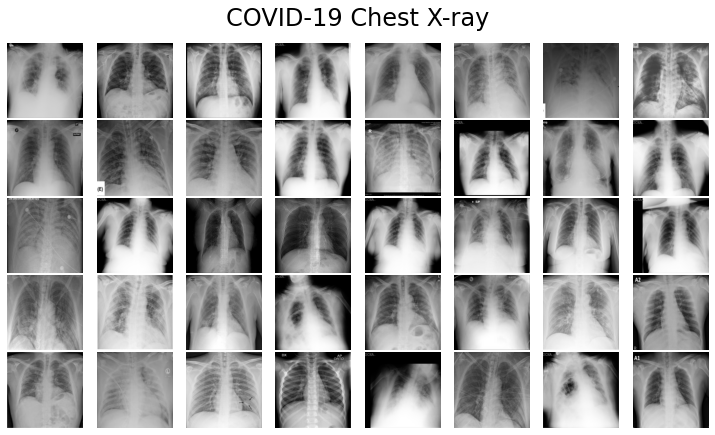

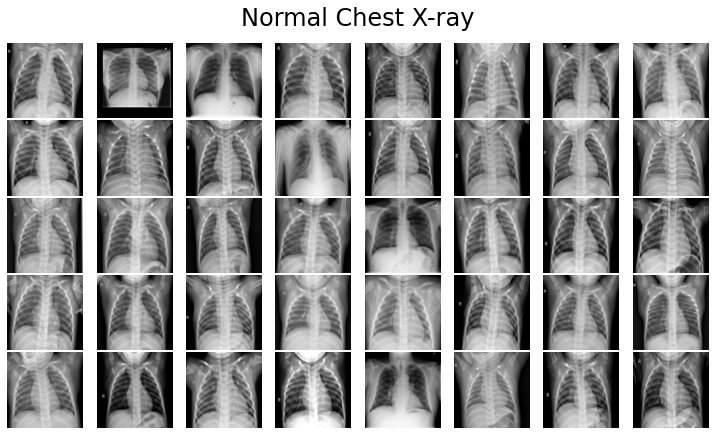

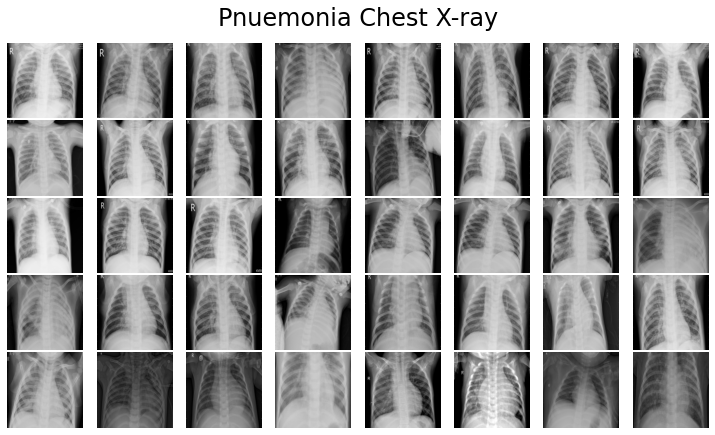

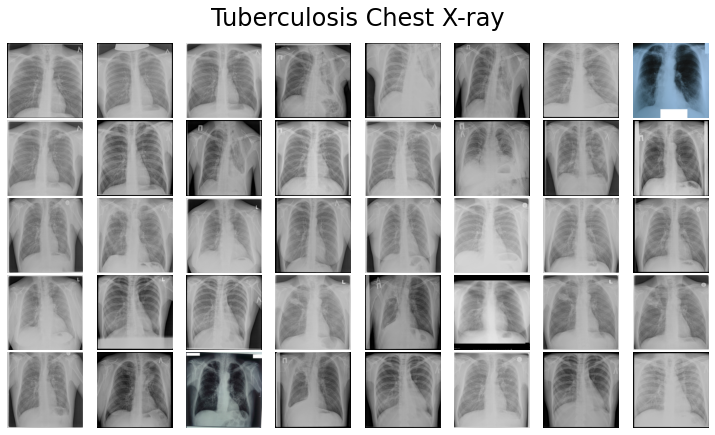

In [ ]:
#Visualizing First 40 Images from Data set

def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()

plot_images(covid_images, 'COVID-19 Chest X-ray')
plot_images(normal_images, 'Normal Chest X-ray')
plot_images(pnuemonia_images, 'Pnuemonia Chest X-ray')
plot_images(tuberculosis_images, 'Tuberculosis Chest X-ray')

In [ ]:
#since model takes images in the form of array of pixels. Hence converting it into array and normalising

covid_images = np.array(covid_images) / 255
normal_images = np.array(normal_images) / 255
pnuemonia_images = np.array(pnuemonia_images) / 255
tuberculosis_images = np.array(tuberculosis_images) / 255

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf

# splitting into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
normal_x_train, normal_x_test, normal_y_train, normal_y_test = train_test_split(
    normal_images, normal_labels, test_size=0.2)
pnuemonia_x_train, pnuemonia_x_test, pnuemonia_y_train, pnuemonia_y_test = train_test_split(
    pnuemonia_images, pnuemonia_labels, test_size=0.2)
tuberculosis_x_train, tuberculosis_x_test, tuberculosis_y_train, tuberculosis_y_test = train_test_split(
    tuberculosis_images, tuberculosis_labels, test_size=0.2)


X_train = np.concatenate((normal_x_train, covid_x_train, pnuemonia_x_train, tuberculosis_x_train), axis=0)
X_test = np.concatenate((normal_x_test, covid_x_test, pnuemonia_x_test, tuberculosis_x_test), axis=0)
y_train = np.concatenate((normal_y_train, covid_y_train, pnuemonia_y_train, tuberculosis_y_train), axis=0)
y_test = np.concatenate((normal_y_test, covid_y_test, pnuemonia_y_test, tuberculosis_y_test), axis=0)

print(y_train)
print(y_test)


[1 1 1 ... 3 3 3]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3]


In [ ]:

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import Xception

vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(4, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False



model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=10,)

Epoch 1/10
51/51 [==============================] - 41s 535ms/step - loss: 1.1553 - accuracy: 0.6146 - val_loss: 0.4602 - val_accuracy: 0.8671
Epoch 2/10
51/51 [==============================] - 22s 420ms/step - loss: 0.5588 - accuracy: 0.8055 - val_loss: 0.4292 - val_accuracy: 0.8623
Epoch 3/10
51/51 [==============================] - 22s 430ms/step - loss: 0.5147 - accuracy: 0.8164 - val_loss: 0.3761 - val_accuracy: 0.8575
Epoch 4/10
51/51 [==============================] - 22s 431ms/step - loss: 0.4747 - accuracy: 0.8444 - val_loss: 0.3414 - val_accuracy: 0.8551
Epoch 5/10
51/51 [==============================] - 22s 435ms/step - loss: 0.5324 - accuracy: 0.8091 - val_loss: 0.3441 - val_accuracy: 0.8744
Epoch 6/10
51/51 [==============================] - 22s 432ms/step - loss: 0.4135 - accuracy: 0.8559 - val_loss: 0.3395 - val_accuracy: 0.8792
Epoch 7/10
51/51 [==============================] - 22s 435ms/step - loss: 0.3900 - accuracy: 0.8565 - val_loss: 0.2718 - val_accuracy: 0.9010

In [ ]:
model.save('vgg_chest2.h5')

In [ ]:
model.save_weights('vgg_chest2.hdf5')

In [ ]:
model = load_model('vgg_chest2.h5')

In [ ]:
#making predictions

y_pred = model.predict(X_test, batch_size=batch_size)

print(y_pred)

y_pred_avg = np.argmax(y_pred,axis=1)

# y_test_avg = np.argmax(y_test, axis=1)

print(y_pred_avg)



[[5.43385722e-05 8.51687312e-01 1.48257658e-01 6.92267463e-07]
 [8.48482251e-01 1.96712017e-02 4.26362356e-04 1.31420270e-01]
 [3.11416488e-06 9.99318957e-01 6.77968317e-04 3.97854443e-08]
 ...
 [2.26169996e-05 1.58338225e-04 1.12999992e-07 9.99818981e-01]
 [9.63174343e-01 7.73685402e-04 6.36791764e-03 2.96840500e-02]
 [6.50953807e-05 5.35732988e-06 1.05919455e-07 9.99929428e-01]]
[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 3 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2
 2 2 1 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2
 1 1 1 2 2 2 0 2 2 2 2 0 2 2 1 2 1 1 1 2 2 2 2 1 2 2 2 2 2 2 2 3 3 3 0 3 3
 3 3 3 3 3 3 3 3

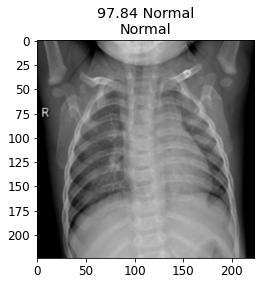

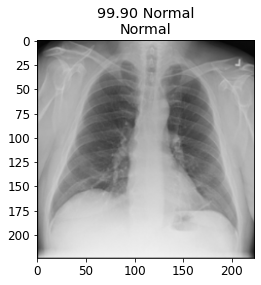

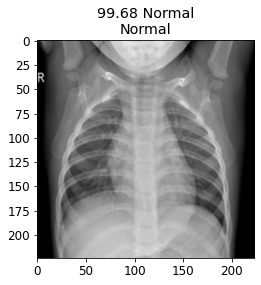

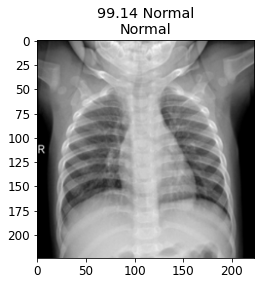

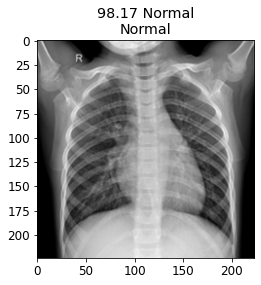

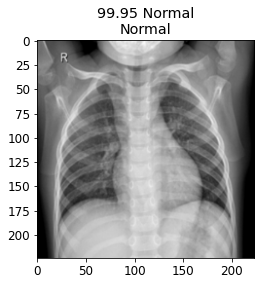

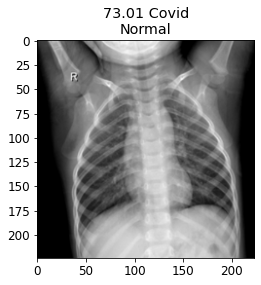

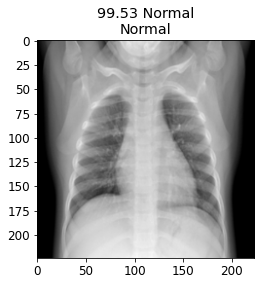

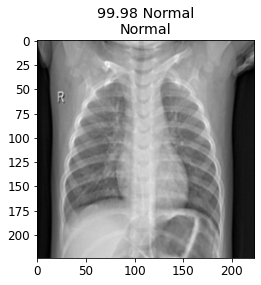

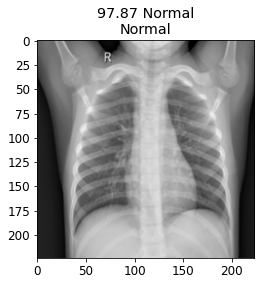

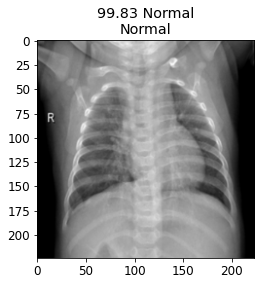

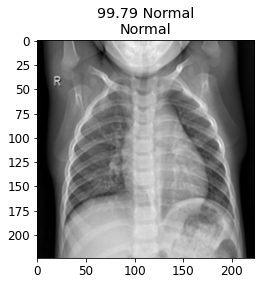

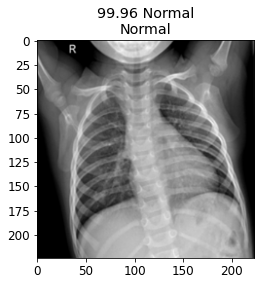

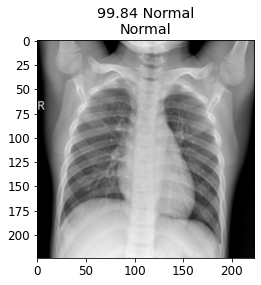

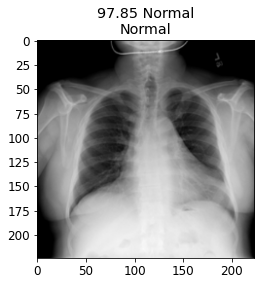

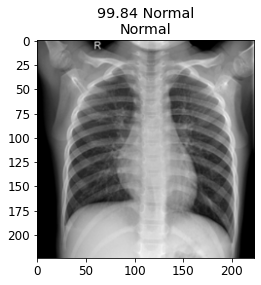

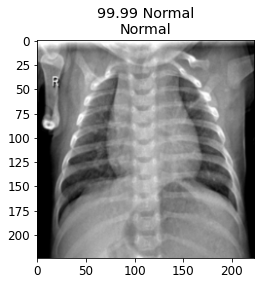

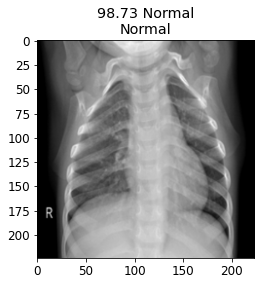

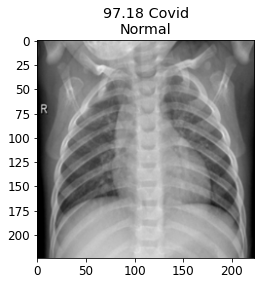

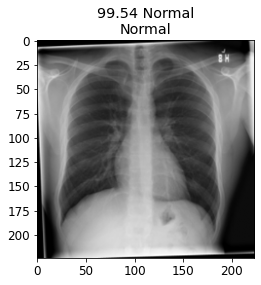

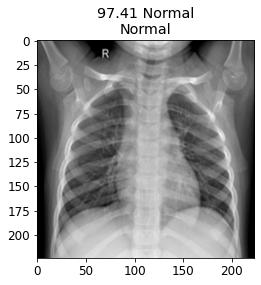

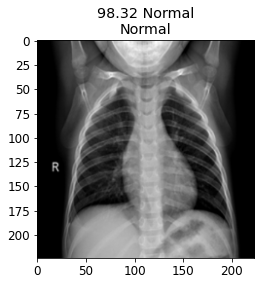

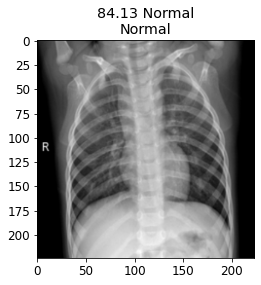

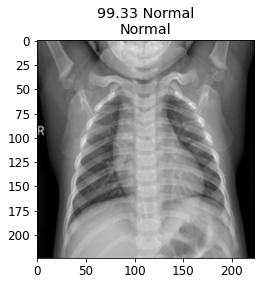

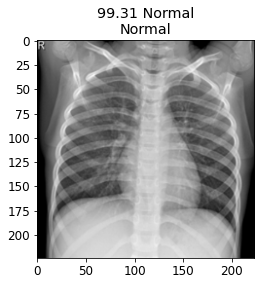

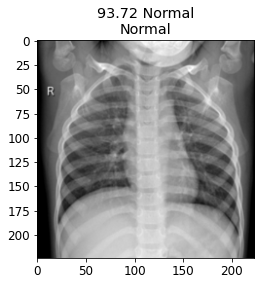

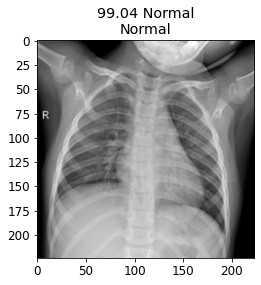

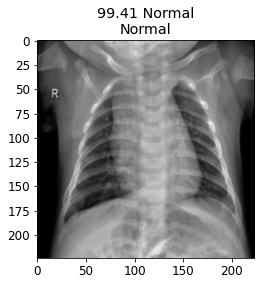

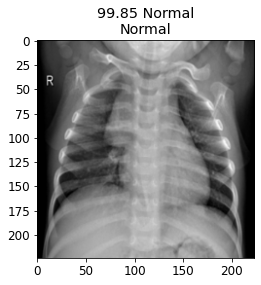

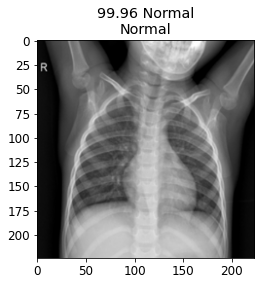

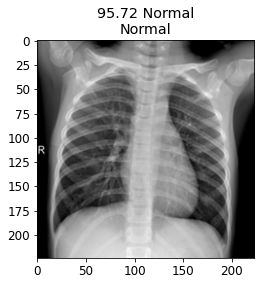

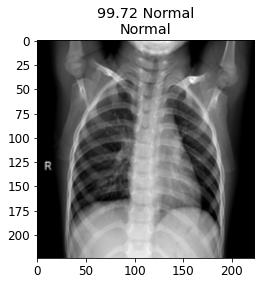

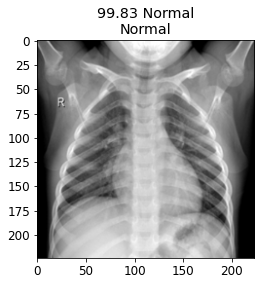

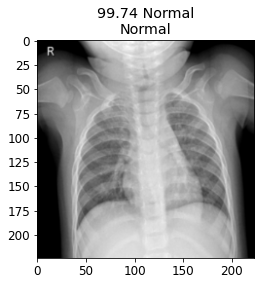

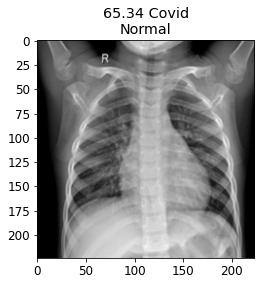

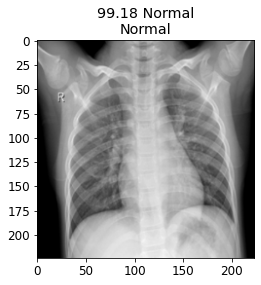

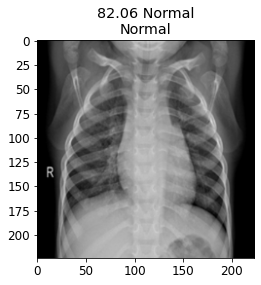

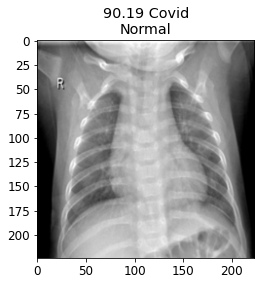

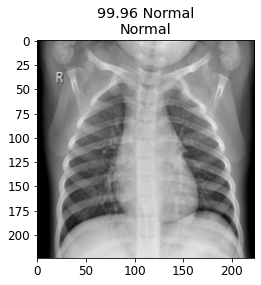

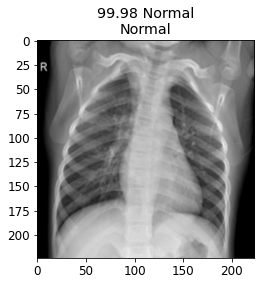

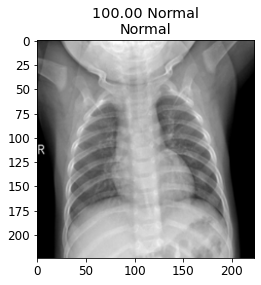

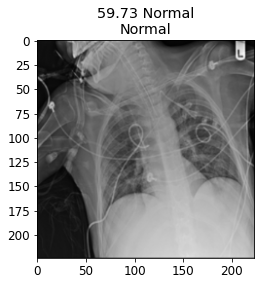

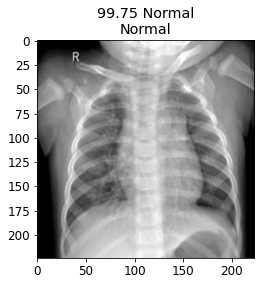

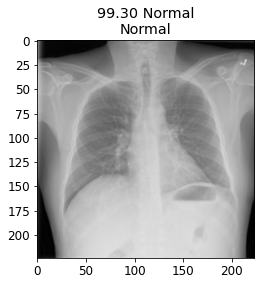

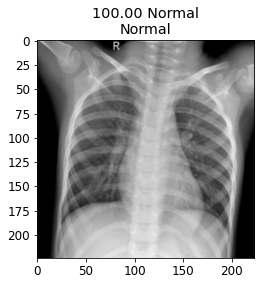

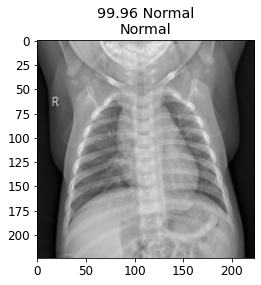

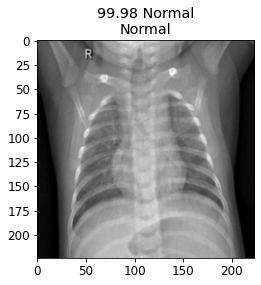

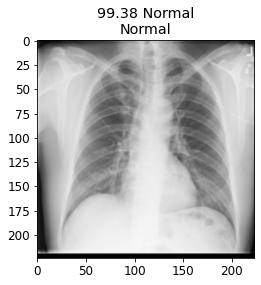

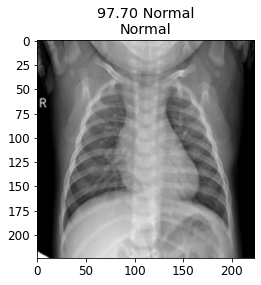

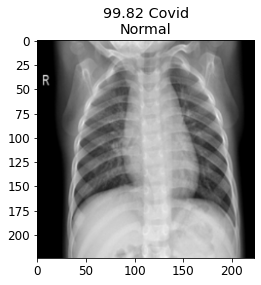

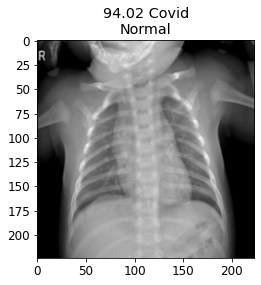

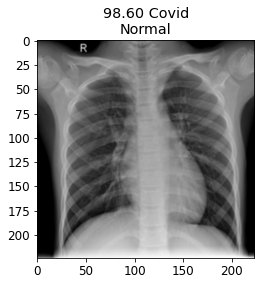

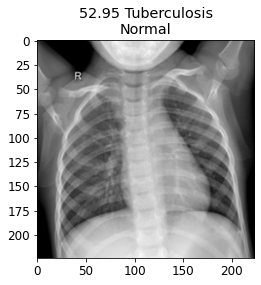

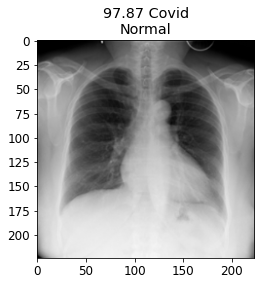

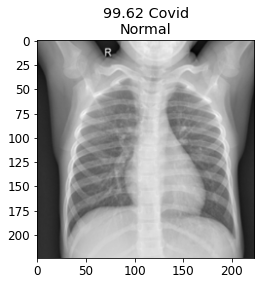

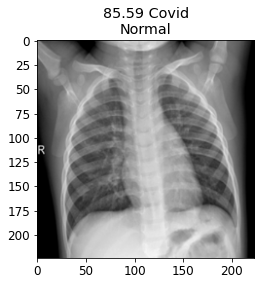

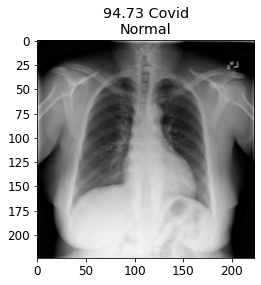

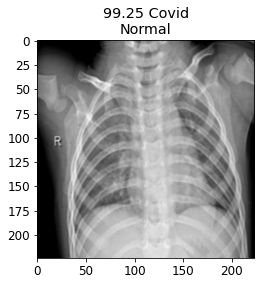

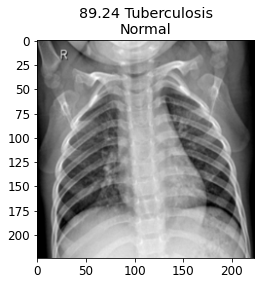

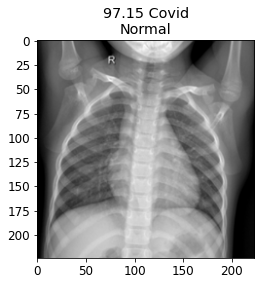

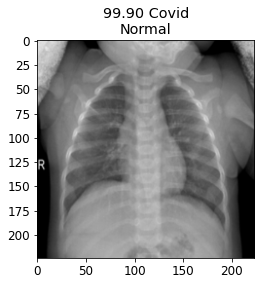

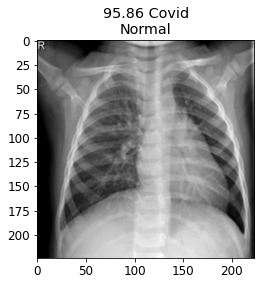

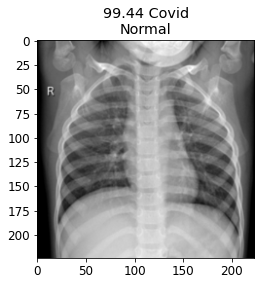

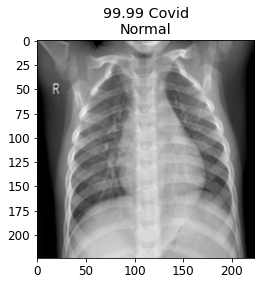

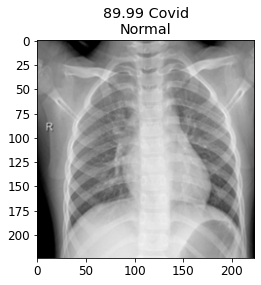

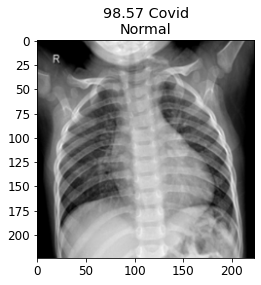

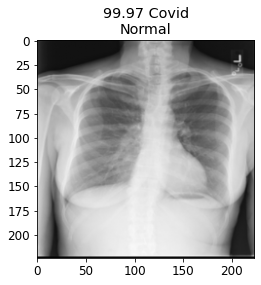

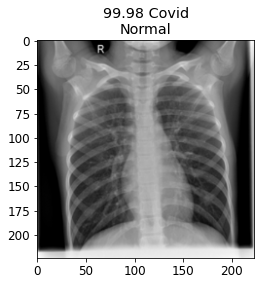

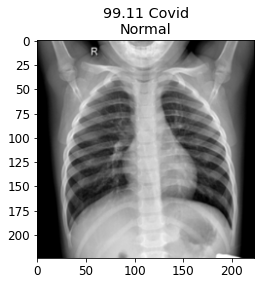

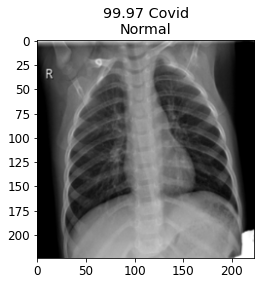

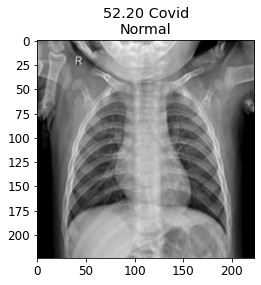

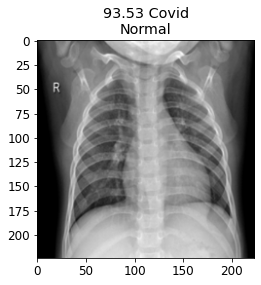

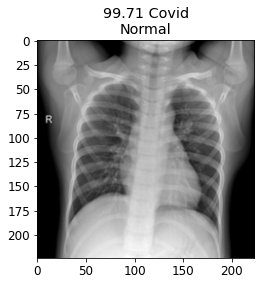

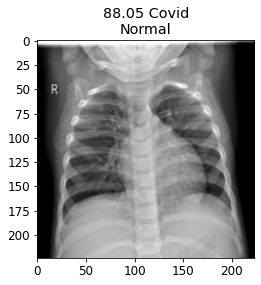

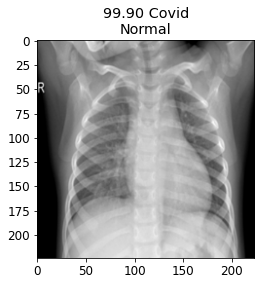

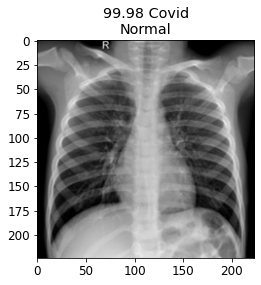

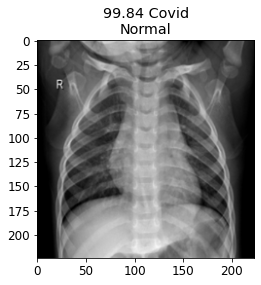

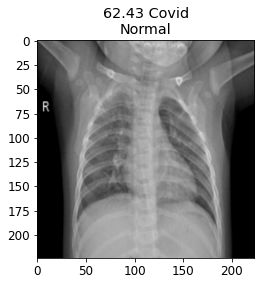

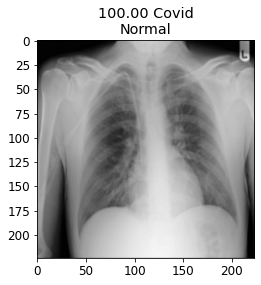

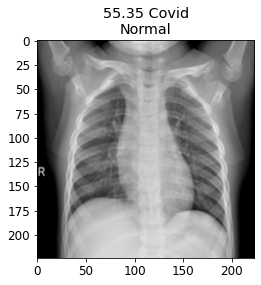

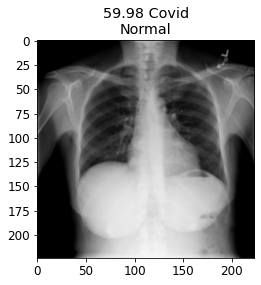

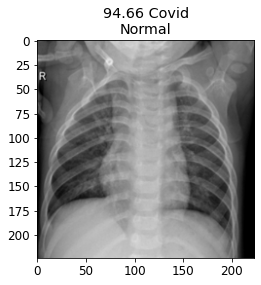

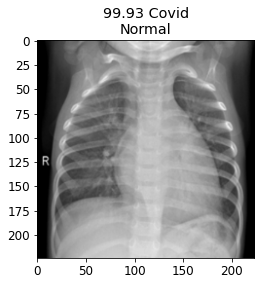

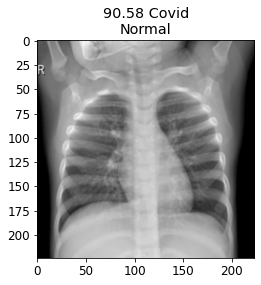

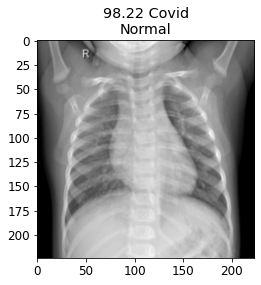

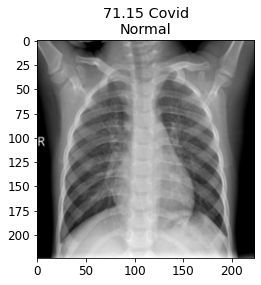

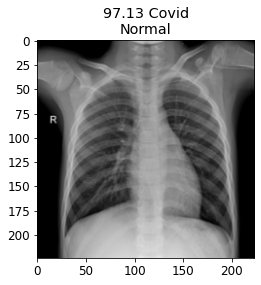

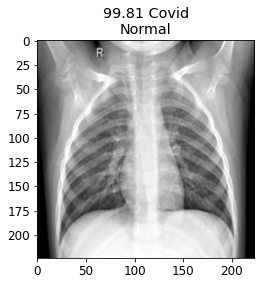

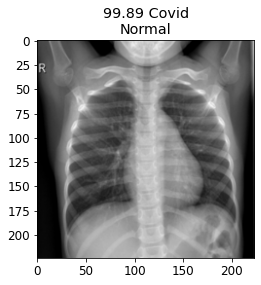

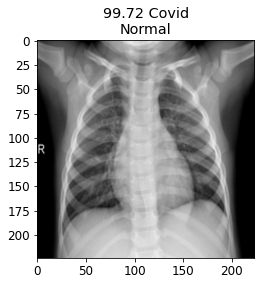

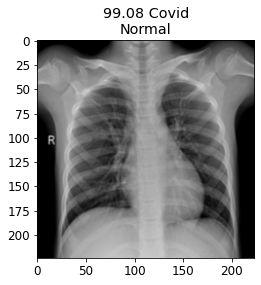

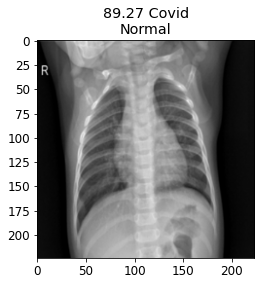

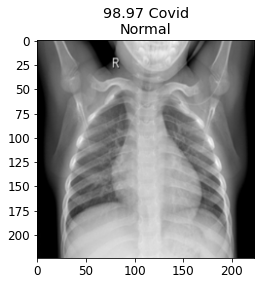

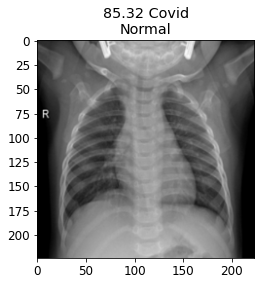

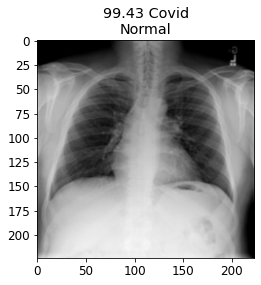

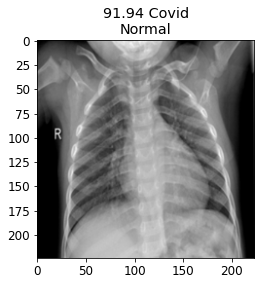

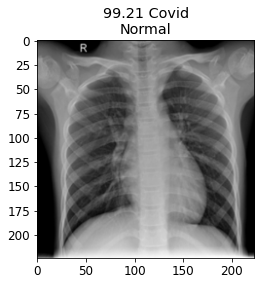

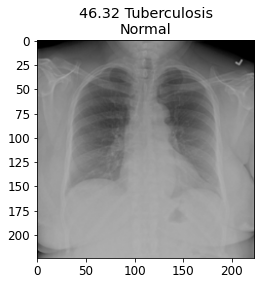

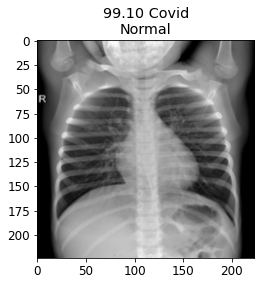

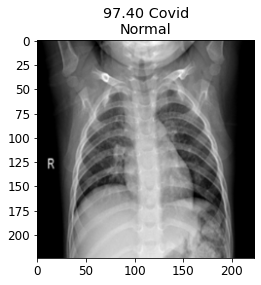

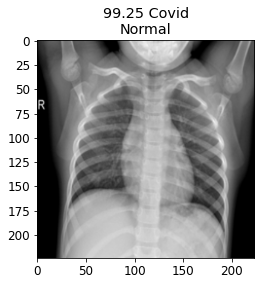

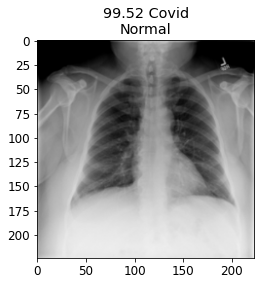

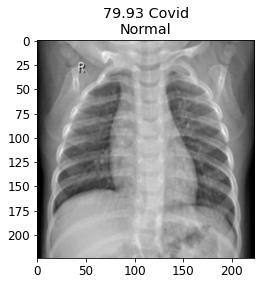

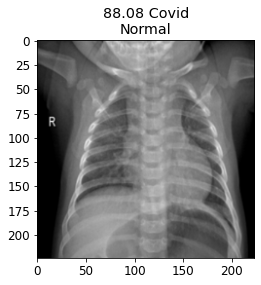

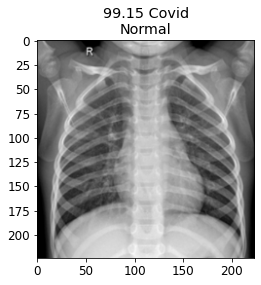

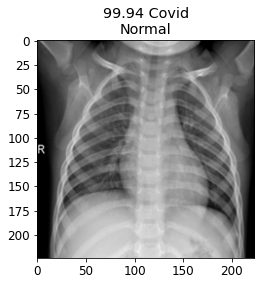

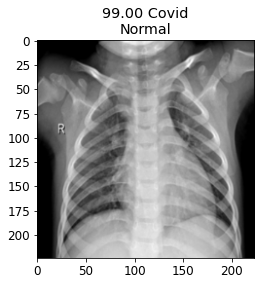

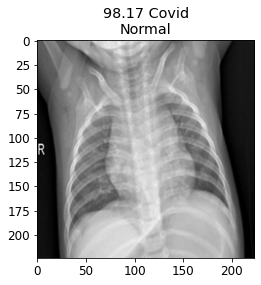

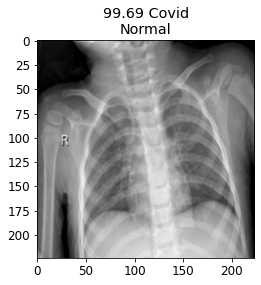

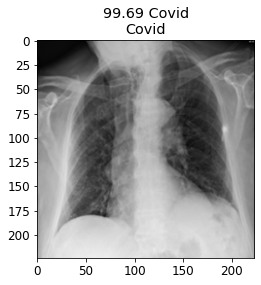

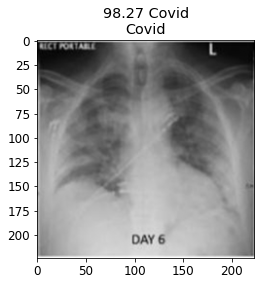

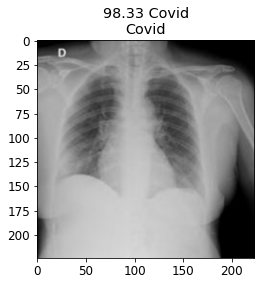

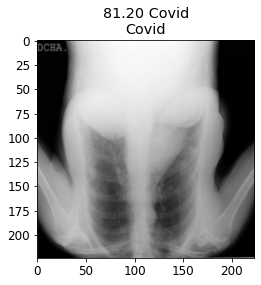

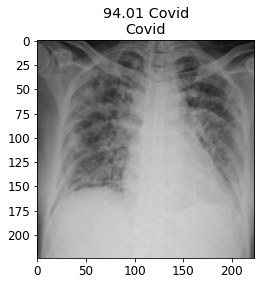

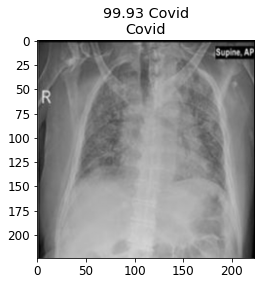

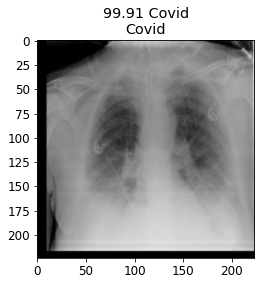

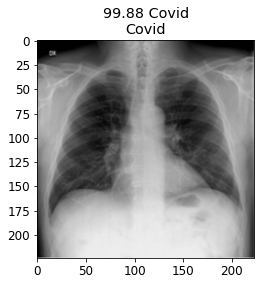

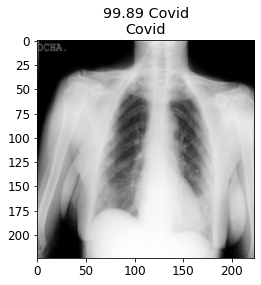

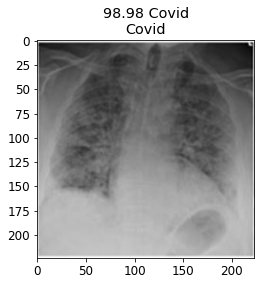

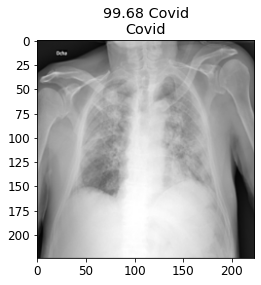

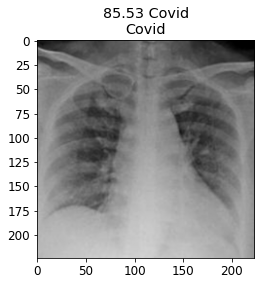

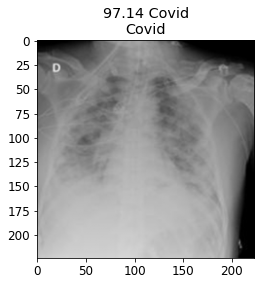

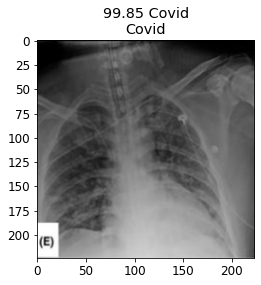

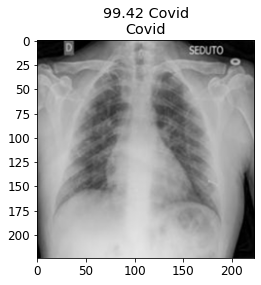

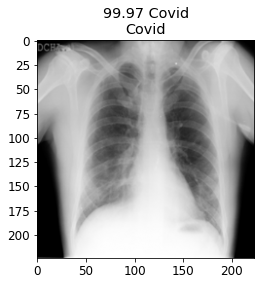

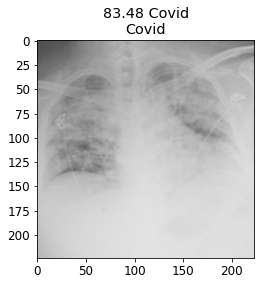

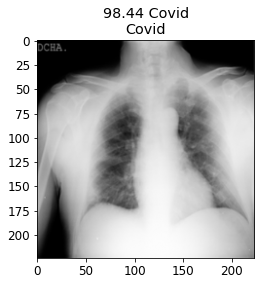

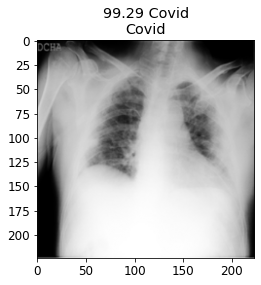

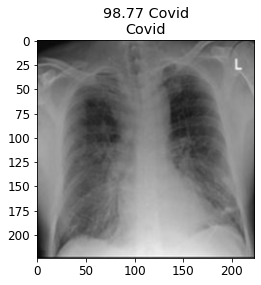

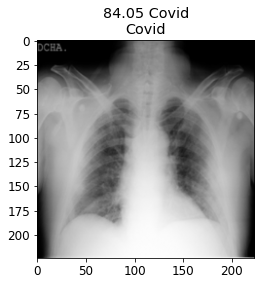

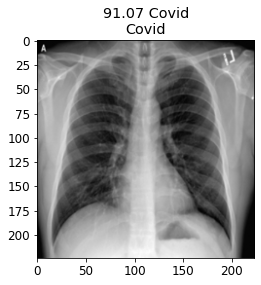

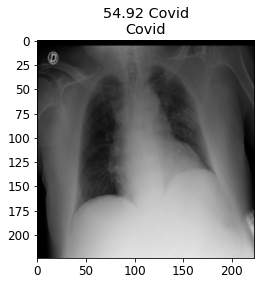

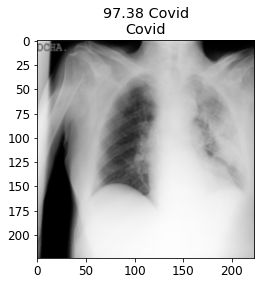

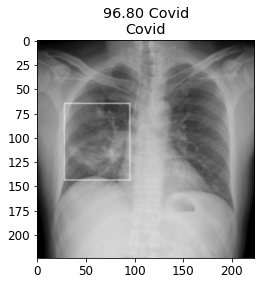

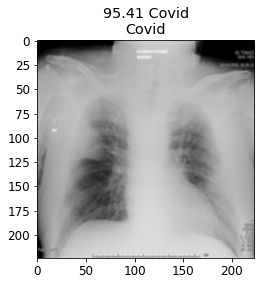

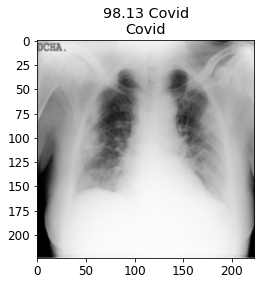

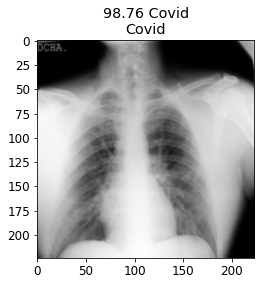

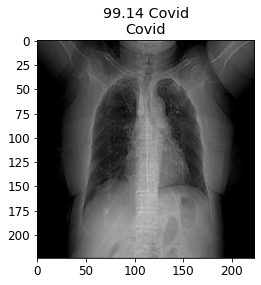

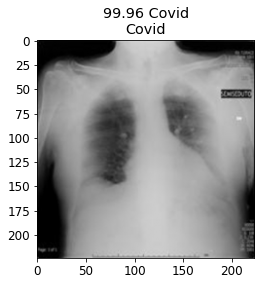

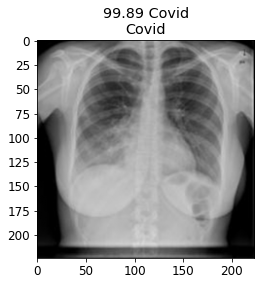

In [ ]:
# Visualizing First 10 predictions
classes = ['Covid','Normal','Pnuemonia','Tuberculosis']
prediction=y_pred[60:200]
predictlabel = y_pred_avg[60:200]
for index, probability in enumerate(prediction):
  # print(probability)
  # print(y_test[index])
  # p = y_test[index]
  # print('%.2f' % (probability[predictlabel[index]]*100) + " "+ classes[predictlabel[index]])
  plt.title('%.2f' % (probability[predictlabel[index]]*100) + " "+ classes[predictlabel[index]]+"\n" + classes[y_test[index]])
  # if probability[1] > 0.5:
  #       plt.title('%.2f' % (probability[1]*100) + '% COVID')
  # else:
  #       plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:

print(y_pred_avg)
print(y_test)

[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 3 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2
 2 2 1 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2
 1 1 1 2 2 2 0 2 2 2 2 0 2 2 1 2 1 1 1 2 2 2 2 1 2 2 2 2 2 2 2 3 3 3 0 3 3
 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 0 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3
 3 0 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 1 3 0 3 0 3 3 3 3 3
 3 3 3 3 3 0 3]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

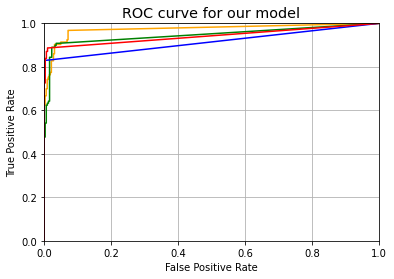

In [ ]:
fpr = {}
tpr = {}
thresh ={}
n_class = 3
t = len(y_test)
c_test =[0]*t
c_pred =[0]*t
n_test =[0]*t
n_pred =[0]*t
p_test =[0]*t
p_pred =[0]*t
t_test =[0]*t
t_pred =[0]*t

for i in range(0,len(y_test)):
  if(y_test[i]==0):
    c_test[i]=1
  if(y_pred_avg[i]==0):
    c_pred[i]=y_pred[i][y_pred_avg[i]]
  if(y_test[i]==1):
    n_test[i]=1
  if(y_pred_avg[i]==1):
    n_pred[i]=y_pred[i][y_pred_avg[i]]
  if(y_test[i]==2):
    p_test[i]=1
  if(y_pred_avg[i]==2):
    p_pred[i]=y_pred[i][y_pred_avg[i]]
  if(y_test[i]==3):
    t_test[i]=1
  if(y_pred_avg[i]==3):
    t_pred[i]=y_pred[i][y_pred_avg[i]]
print(c_test,"\n",c_pred)
print(n_test,"\n",n_pred)


fpr, tpr, thresholds = roc_curve(c_test, c_pred)
plt.plot(fpr, tpr , color='orange', label='Covid')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

fpr, tpr, thresholds = roc_curve(n_test, n_pred, )
plt.plot(fpr, tpr,color='green', label='Normal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

fpr, tpr, thresholds = roc_curve(p_test, p_pred)
plt.plot(fpr, tpr, color='blue', label='Pnuemonia')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

fpr, tpr, thresholds = roc_curve(t_test, t_pred)
plt.plot(fpr, tpr,color='red', label='Tuberculosis')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)



Confusion Matrix without Normalization


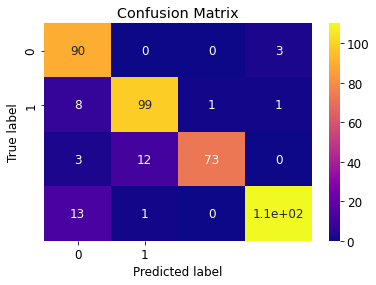

Confusion Matrix with Normalized Values


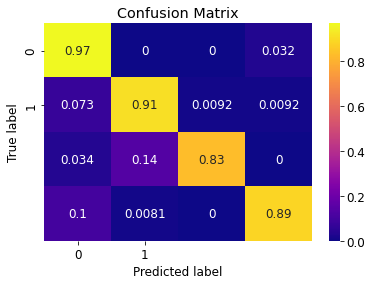

In [ ]:
#plotting confusion matrix


def plot_confusion_matrix(normalize):
  classes = [0,1,2,3]
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test, y_pred_avg,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
#report for classification

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_avg))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87        93
           1       0.88      0.91      0.90       109
           2       0.99      0.83      0.90        88
           3       0.96      0.89      0.92       124

    accuracy                           0.90       414
   macro avg       0.91      0.90      0.90       414
weighted avg       0.91      0.90      0.90       414



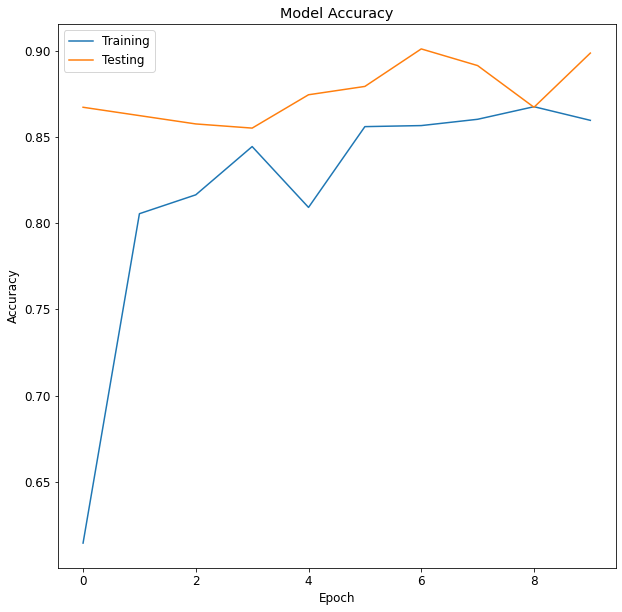

In [ ]:
#accuracy plots

plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_accuracy.png')
plt.show()

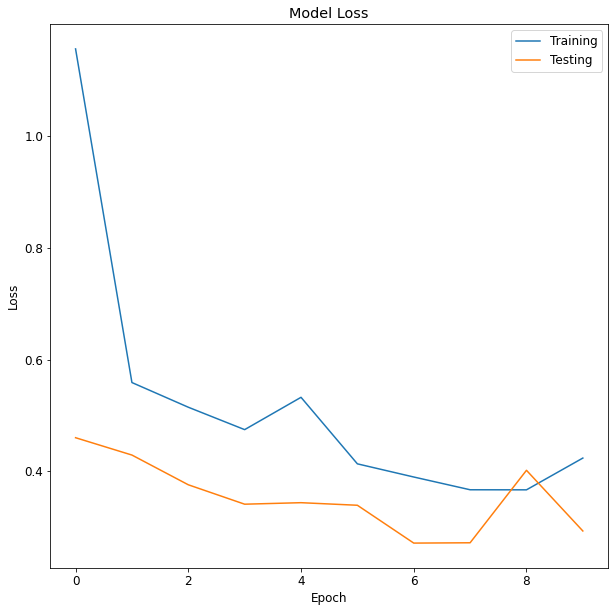

In [ ]:
#model loss
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_loss.png')
plt.show()